# Seattle Weather Prediction
I have two objectives with this notebook. First, I want to use it to illustrate some of the points that I made in the [related article](https://nrlewis929.medium.com/the-benefits-of-machine-learning-for-the-renewable-energy-sector-4315efae588e) on why data science and machine learning is an important tool in tackling some of the grand challenges of engineering related to energy. They include: 

1. We can get preliminary results fast, rather than spending years on something that might not even work.
2. We can leverage machine learning to gain additional insights or to verify intuition using an unbiased mechanism.
3. We can facilitate interdisciplinary collaboration between domain experts with a common language and methodology.

Secondly, I want to introduce a few nuances and strategies that you might come across in classification problems. Hopefully as you see me select options for my model, you can learn some strategies that might help you out!

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Sklearn preprocessing packages
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### Data Processing

First, we will read in the data into a pandas dataframe. The original data is available from [Kaggle](https://www.kaggle.com/datasets/ananthr1/weather-prediction?resource=download). We'll also display the datatypes so that we know what we're working with.

In [2]:
# Load dataframe 
df = pd.read_csv('seattle-weather.csv')
print(df.dtypes)

date              object
precipitation    float64
temp_max         float64
temp_min         float64
wind             float64
weather           object
dtype: object


There are countless ways to start looking at data to get a sense of what we're working with. Some of my favorites that are easy to use with just one line of code are `df.describe()` and seaborn pairplots. You can also selectively describe portions of the data frame by some of the example code below.

We want to make sure that we take care of any data that has missing values or suspicious outliers. Thankfully, this is a really nice dataset that doesn't have many of those real-world issues, so we can almost start using it as-is!

In [3]:
df.describe()
# df[df['weather'] == 'drizzle'].describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


Pairplots are a fast and effective way to get an idea of distributions and correlations of data. If you have lots of data such that the datapoints overlap, consider setting `kind='hist`.

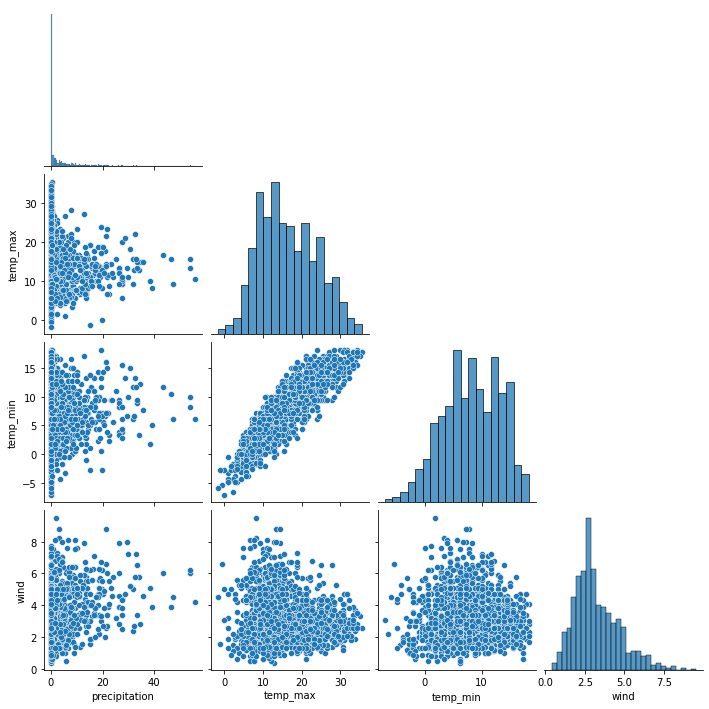

In [4]:
sns.pairplot(df,corner=True)

### Data Engineering
Here is where we get to be creative! We have only a limited number of features at this point, and we want to be able to predict the category of weather. Are there any additional features that we could end up using? Consider not only the high and low temperature, but also the temperature range in a given day. We may also have seasonal variations that affect the weather, so we can include a categorical season variable and one-hot encode it. Finally, since we are using a logistic regression, which is only able to learn linear relationships, we have the option of adding nonlinearity by creating terms that are the square, square root, or log of the original features.

In [5]:
# Convert timestamp to datetime 
df['date'] = pd.to_datetime(df['date'])

# Calculate temperature range
df['temp_range'] = df['temp_max'] - df['temp_min']

# Encode the weather label 
le = LabelEncoder()
df['weather_label']=le.fit_transform(df['weather'])

# Optionally add nonlinearity to each feature
base_features=['precipitation', 'temp_max', 'temp_min', 'wind']
features = base_features.copy()
# for feature in base_features:
#     df[feature+'2'] = df[feature] ** 2
#     features.append(feature+'2')
#     df['sqrt_'+feature] = df[feature] ** 0.5
#     features.append('sqrt_'+feature)
#     df['log_'+feature] = np.log(df[feature] + 1)
#     features.append('log_'+feature)
    
# Encode the season
season_map = {1:'Winter',
     2:'Winter',
     3:'Spring',
     4:'Spring',
     5:'Spring',
     6:'Summer',
     7:'Summer',
     8:'Summer',
     9:'Autumn',
     10:'Autumn',
     11:'Autumn',
     12:'Winter'
    }

df['season'] = df['date'].dt.month.map(season_map)
df = pd.get_dummies(df,columns=['season'])

# Final list of features
features = features + ['temp_range','season_Spring','season_Summer','season_Autumn','season_Winter']

print(features)


['precipitation', 'temp_max', 'temp_min', 'wind', 'temp_range', 'season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter']


Now we're into familiar ML territory. To prepare for the model, we gather that input features and target data, split it into a train and test set, and scale (this is really important for logistic regression, especially when we will be using l1-regularization!)

In [6]:
# Split data into input features (X) and target (y)
X = df[features]
y = df['weather_label']

# Train/test split
Xtrain, Xtest, y_train, y_test = train_test_split(X, y, shuffle = True)

# Scale data
s = MinMaxScaler()
X_train = s.fit_transform(Xtrain)
X_test = s.transform(Xtest)

Let's see how this does out of the box with a logistic regression and default hyperparameters

Score: 0.7295081967213115
Class predictions (array([2, 4]), array([167, 199], dtype=int64))


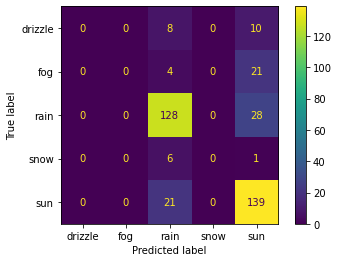

In [10]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)
print('Score:',clf.score(X_test,y_test))
print('Class predictions',np.unique(y_pred, return_counts=True))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
disp.plot()
plt.show()

The first thing to note is that this behaves almost like a majority class classifier. There are only predictions for rain and sun, which are the most common labels. To fix this, we realize that this is an unbalanced classification problem. Luckily, scikit-learn's [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) allows us to assign a `class_weight` to help with the imbalance!

In [7]:
class_weight = {}
n_samples = len(y_train)
n_classes = 5
for class_number, count in enumerate(np.bincount(y_train)):
    print(f'{le.classes_[class_number]}: {count}')#class_number, count)
    class_weight[class_number] = n_samples / (n_classes * count)
print(class_weight)

drizzle: 35
fog: 76
rain: 485
snow: 19
sun: 480
{0: 6.257142857142857, 1: 2.8815789473684212, 2: 0.4515463917525773, 3: 11.526315789473685, 4: 0.45625}


Score: 0.4644808743169399
Class predictions (array([0, 1, 2, 3, 4]), array([ 70,  70, 112,  29,  85], dtype=int64))


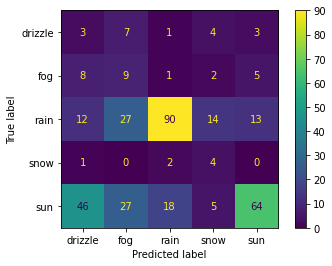

In [11]:
clf = LogisticRegression(class_weight=class_weight)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)
print('Score:',clf.score(X_test,y_test))
print('Class predictions',np.unique(y_pred, return_counts=True))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
disp.plot()
plt.show()

It's not great, but at least it's not only giving the most common predictions. We'll play around with the other hyperparameters, but the significant step that we want to take is to deploy a regularization term. This is typically used to prevent overfitting of data, but can also be a powerful tool in feature importance. On a surface level, what we are doing is adding a regularization term, C, that decreases the weight of the coefficients in the logistic regression model. As we increase the weight (which is inversely proportional to C), the coefficients become smaller and smaller. We can readily see which coefficients are the greatest for a given C. Larger coefficients have a larger impact in the classification decision. Interestingly, with l1-regularization, the derivative allows the coefficients to go to 0. We can see which coefficients go to 0 first, and those are the first features that we can drop out. 

For more information on regularization methods, visit [this post](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c). Note that most of the hyperparameters selected in the models below are required to use l1-regularization with a logistic regression model in scikit-learn.

C: 0.01
Score: 0.06830601092896176
Class predictions (array([1]), array([366], dtype=int64))


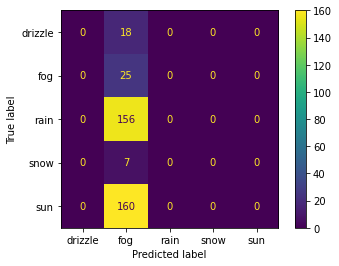

C: 0.1
Score: 0.5655737704918032
Class predictions (array([0, 1, 2, 3, 4]), array([ 15,   9, 157,  59, 126], dtype=int64))


C:\Users\Nicholas\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


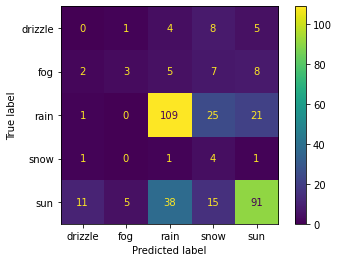

C:\Users\Nicholas\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C: 1.0
Score: 0.6530054644808743
Class predictions (array([0, 1, 2, 3, 4]), array([ 60,   4, 108,  19, 175], dtype=int64))


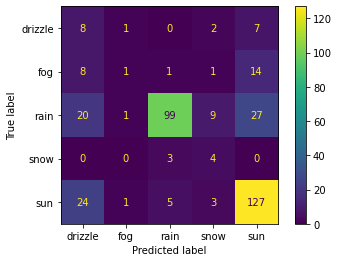

C: 10.0
Score: 0.45081967213114754
Class predictions (array([0, 1, 2, 3, 4]), array([ 91,  86, 108,  35,  46], dtype=int64))


C:\Users\Nicholas\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


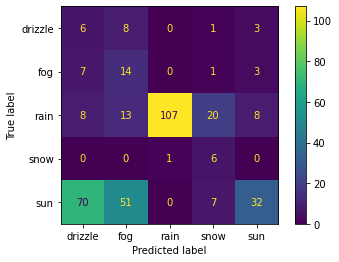

C:\Users\Nicholas\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C: 100.0
Score: 0.6038251366120219
Class predictions (array([0, 1, 2, 3, 4]), array([ 68,  67, 143,  14,  74], dtype=int64))


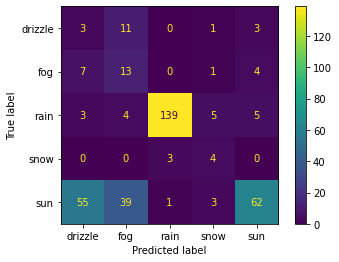

C:\Users\Nicholas\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C: 1000.0
Score: 0.8032786885245902
Class predictions (array([1, 2, 3, 4]), array([  9, 139,  17, 201], dtype=int64))


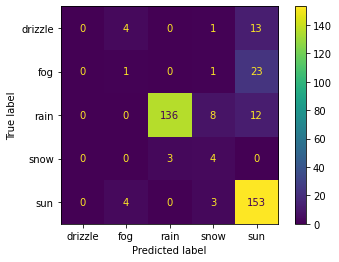

C:\Users\Nicholas\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C: 10000.0
Score: 0.4262295081967213
Class predictions (array([0, 1, 2, 3, 4]), array([112, 101, 127,  20,   6], dtype=int64))


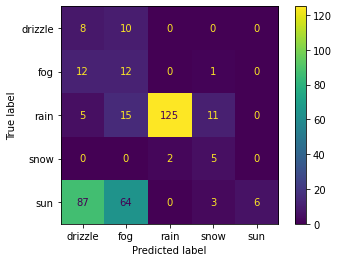

C:\Users\Nicholas\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C: 100000.0
Score: 0.7486338797814208
Class predictions (array([0, 1, 2, 3, 4]), array([ 44,  13, 141,  16, 152], dtype=int64))


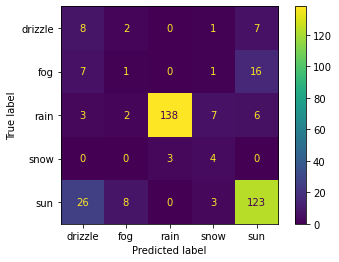

In [15]:
# Define a log distribution of regularization coefficients
Cs = np.logspace(-2, 5, 8)

# Create dataframes to store values
coef_dfs = [pd.DataFrame(columns=features,index=Cs)] * 5

# Iterate over regularization coefficients; train model, predict on test set, and display metrics
for C in Cs:
    # Initialize model
    clf = LogisticRegression(solver = 'saga',penalty='l1', max_iter = 10000, tol=0.001,
                             C = C, class_weight=class_weight, multi_class = 'multinomial')
    # Fit model
    clf.fit(X_train, y_train)
    # Make predictions
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)
    # Store coefficients
    for i,coef_df in enumerate(coef_dfs):
        coef_df.loc[C] = clf.coef_[i]
        
    # Display metrics and confusion matrix
    print('C:',C)
    print('Score:',clf.score(X_test,y_test))
    print('Class predictions',np.unique(y_pred, return_counts=True))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=le.classes_)
    disp.plot()
    plt.show()
#     plt.savefig('confusion_matrix'+str(C)+'.png',dpi=300)
    

After all this work, it's not a great classifier. I got much better results right away out of the box with [xgboost](https://xgboost.readthedocs.io/en/stable/). You may note the warning that the maximum number of iterations was reached and didn't converge. Interestingly, as I increased the iterations, I never got it to converge, and the result was just a continued increase in the weight for `precipitation`. I also played with the tolerance, and still didn't get it to converge. This is all teaching me that logistic regression probably isn't the best option for this problem. 

I chose this particular model, though, so that we could use l1-norm regularization. As we increased the regularization term (which is inverse to `C`), we see the weights for each feature go to 0. This functionality is primarily used to prevent overfitting, but also shows us interesting things about the features. First of all, we see that the weight for `precipitation` far exceeds any other feature...no surprise there! The best way to predict if it's sunny or rainy is if there's precipitation. (Side note: make sure you have normalized your data before doing this, otherwise your weights will have artifacts related to the order of magnitude for your data! For example, if precipitation were measured in mm instead of inches, and not normalized, your model would return different weights.) What's the second largest weight when there is minimal regularization? It looks like `temp_max` and `temp_min` are pretty important as well. Interestingly, as the regularization term increases (or `C` decreases), the spread of the temperature becomes more important. If we were only to select 3 features, which would you select and why?

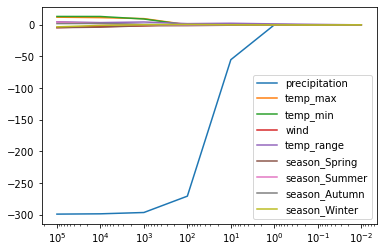

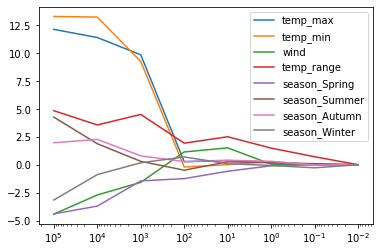

In [9]:
# Select coefficients for which weather_label to plot
weather_label = 0

# Plot the coefficients at different regularization strengths
coef_dfs[weather_label].plot(logx=True)
plt.gca().invert_xaxis()
plt.show()

sub_features = features.copy()
sub_features.remove('precipitation')
coef_dfs[weather_label][sub_features].plot(logx=True)
plt.gca().invert_xaxis()
plt.show()

There we have it. It's one method of many, and not even the best one for this particular case. But you know what? I like that! I like putting something out there that's not polished and perfect. It shows that machine learning can be an iterative process. We still learned some valuable lessons. Perhaps for the final model we can use some feature selection methods from [scikit-learn](https://scikit-learn.org/stable/modules/feature_selection.html). Or maybe we can use random forests or gradient boosting. I'm excited to see what you can get out of this!